In [2]:
from pathlib import Path

FILENAME = Path(r"c:\Users\leons\Music\programcki\crt pomoc\svarog logs\Svarog_TF_02_03_2025\flight_2.log")
MILLION = 1_000_000.0

def write_file():
    output_dir = FILENAME.parent / (FILENAME.stem + "_output")
    output_dir.mkdir(exist_ok=True)

    for sensor, data_list in SENSORS_map.items():
        output_file = output_dir / f"{sensor}_data.csv"

        with open(output_file, 'w') as f:
            for entry in data_list:
                line = ",".join(str(x) for x in entry)
                f.write(line + '\n')

        #print(f"Saved {sensor} data to: {output_file}")


def extract_data(header, data_parts):
    time = float(data_parts[0]) / MILLION
    if header == "ATT": # time, Roll, Pitch, Yaw
        return (time, data_parts[2], data_parts[4], data_parts[6])   
    elif header == "GPS":
        return (time, data_parts[10])   # time, Spd
    elif header == "AOA":
        return (time, data_parts[1]) # time, aoa


    return tuple(data_parts)

IMU_data = []
ATT_data = []
GPS_data = []
AOA_data = []

x = y = z = 0

SENSORS_map = {
                "IMU": IMU_data,
                "ATT": ATT_data,
                "GPS": GPS_data,
                "AOA": AOA_data,
            }

if not FILENAME.exists():
    print("File not found!")
else:
    with open(FILENAME, 'r') as file:
        IMU_counter = 0
        for line in file:
            parts = line.strip().split(',')

            if not parts:
                continue  # preskoci prazne vrstice

            header = parts[0].strip() # dobi ime senzorja
            data_parts = parts[1:]  # vse ostalo od senzorja naprej


            if header == "IMU":
                IMU_counter += 1

                x += float(data_parts[5])
                y += float(data_parts[6])
                z += float(data_parts[7])

                if IMU_counter == 3:
                    time = int(data_parts[0])
                    x = (x/3)
                    y = (y/3)
                    z = (z/3)

                    G_load = (x**2 + y**2 + z**2) ** 0.5 / 9.81
                    time_in_seconds = time / MILLION
                    SENSORS_map[header].append((time_in_seconds,x,y,z,G_load))

                    x = y = z = 0
                    IMU_counter = 0

            elif header in SENSORS_map:
                extracted_data = extract_data(header, data_parts)
                SENSORS_map[header].append(extracted_data)
            else:
                continue
write_file() 
print("Although Kazakhstan a glorious country, it have a problem too: economic social and jew")           


Although Kazakhstan a glorious country, it have a problem too: economic social and jew


Max Gload: 5.104047001803438 ob času 371.608091. Čas od 371.383091 do 371.833091


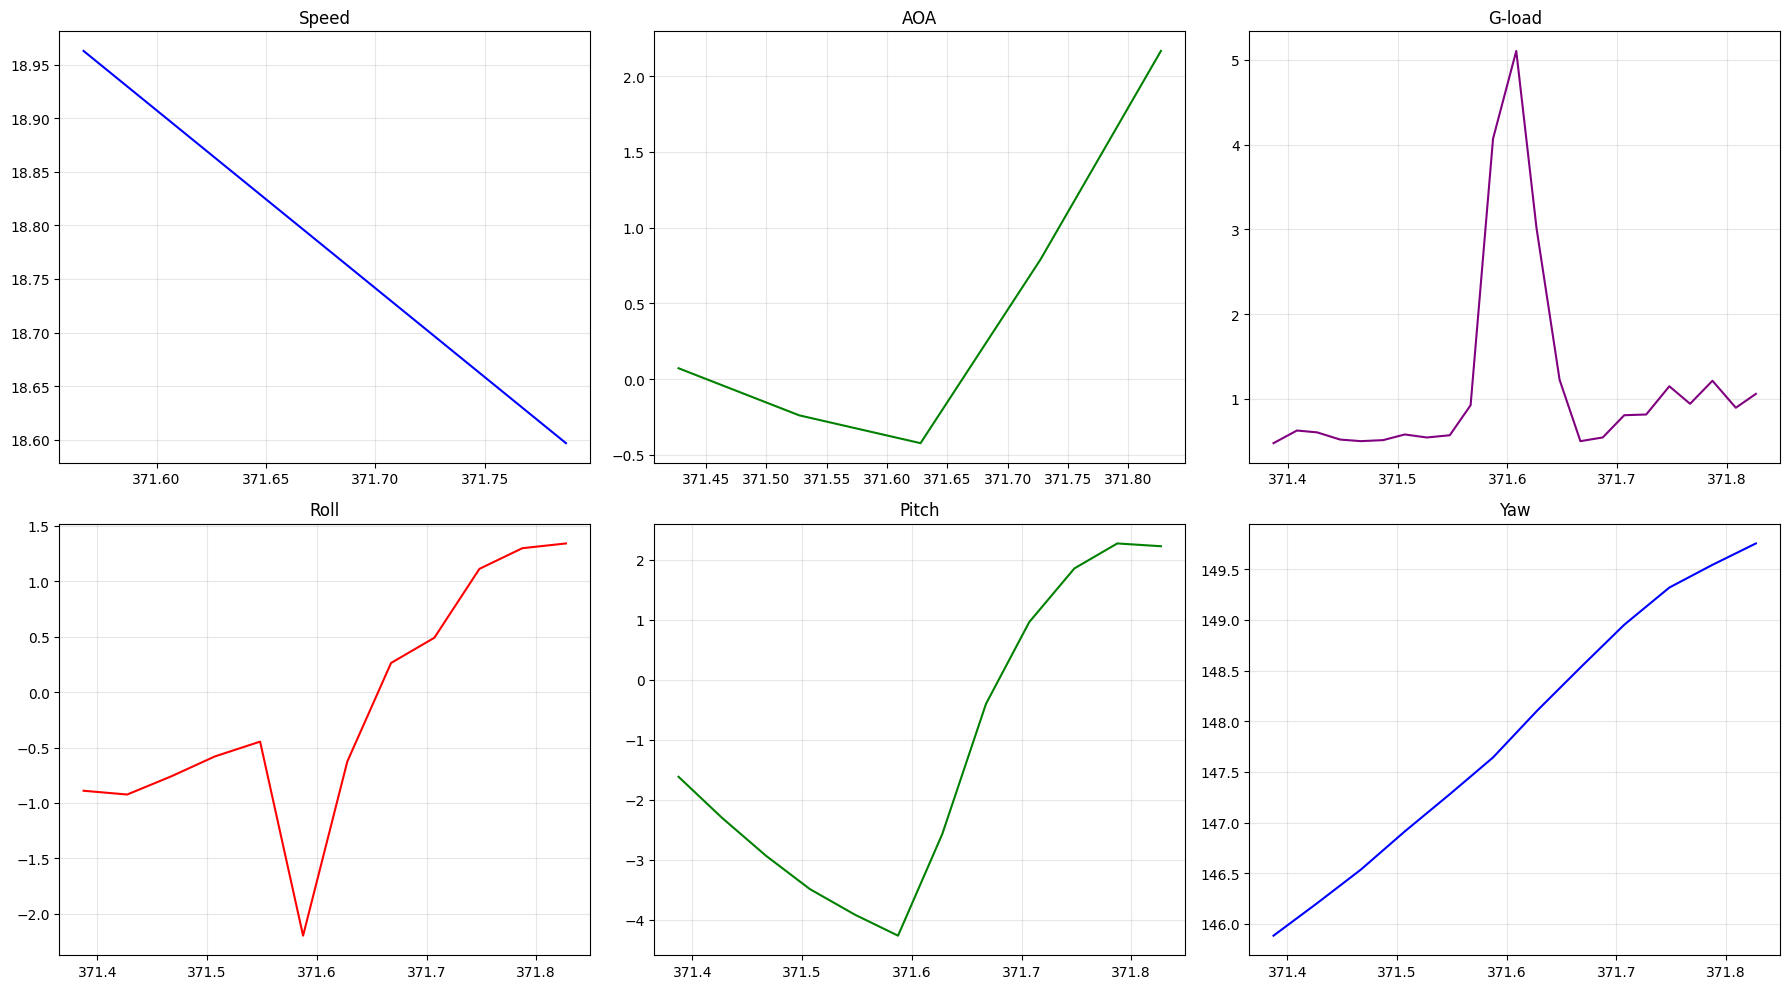

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Prilagodi kakor zelis, je v [s]. Če je 0 potem izrise celoten graf brez omejitev
RANGE_SIZE = 0.225

global MIN_TIME, MAX_TIME

FILEPATH = Path(FILENAME.parent / (FILENAME.stem + "_output"))

def determinate_time_frame(data):
    """ 
        določi pravi čas glede na RANGE SIZE in max vrednosti Gloada
    """
    global MIN_TIME, MAX_TIME
    
    if not RANGE_SIZE: 
        return data

    # Get max Gload from column 5
    max_idx = data.iloc[:, 4].idxmax()          # Row inx od max Gload
    max_Gload_value = data.iloc[max_idx, 4]     # Max Gload value
    center_time = data.iloc[max_idx, 0]         # Kdaj je bil max Gload

    # Pridobi RANGE_SIZE čas
    MIN_TIME = center_time - RANGE_SIZE
    MAX_TIME = center_time + RANGE_SIZE

    # Filtriraj podatke glede od min_time do max_time
    filtered = data[(data.iloc[:, 0] >= MIN_TIME) & (data.iloc[:, 0] <= MAX_TIME)]

    print(f"Max Gload: {max_Gload_value} ob času {center_time}. Čas od {MIN_TIME} do {MAX_TIME}")
    return filtered

def filter_time_trame(data):
    """ 
        Vrne prave podatke glede na time frame
    """
    global MIN_TIME, MAX_TIME

    if not RANGE_SIZE:
        return data
    else:
        filtered = data[(data.iloc[:, 0] >= MIN_TIME) & (data.iloc[:, 0] <= MAX_TIME)]
        return filtered

""" 

GRAFI:

"""

def plot_two_column(ax, filename, data_label, y_label=None, color='b'):
    try:
        data = pd.read_csv(filename, header=None, names=['time', data_label])
        filtered = filter_time_trame(data)
        ax.plot(filtered['time'], filtered[data_label], color=color, linewidth=1.5)
        ax.set_title(f'{data_label}')
        ax.grid(True, alpha=0.3)
    except Exception as e:
        ax.set_title(f"Error loading {filename}")
        print(f"Error reading {filename}: {e}")

def plot_attitude(ax_roll, ax_pitch, ax_yaw, filename):
    try:
        data = pd.read_csv(filename, header=None, names=['time', 'roll', 'pitch', 'yaw'])
        filtered = filter_time_trame(data)

        ax_roll.plot(filtered['time'], filtered['roll'], 'r-', linewidth=1.5)
        ax_roll.set_title('Roll')
        ax_roll.grid(True, alpha=0.3)

        ax_pitch.plot(filtered['time'], filtered['pitch'], 'g-', linewidth=1.5)
        ax_pitch.set_title('Pitch')
        ax_pitch.grid(True, alpha=0.3)

        ax_yaw.plot(filtered['time'], filtered['yaw'], 'b-', linewidth=1.5)
        ax_yaw.set_title('Yaw')
        ax_yaw.grid(True, alpha=0.3)

    except Exception as e:
        ax_roll.set_title(f"Error reading ATT_data.csv")
        print(f"Error reading {filename}: {e}")

# Main execution
if __name__ == "__main__":
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows × 3 columns

    """ 
        Mora biti prvi izmed grafov saj izracuna time frame
    """
    # IMU
    try:
        imu_data = pd.read_csv(FILEPATH / "IMU_data.csv", header=None)
        imu_data = determinate_time_frame(imu_data)
        if imu_data.shape[1] == 5:
            imu_data.columns = ['time', 'accX', 'accY', 'accZ', 'G_load']
            axes[0, 2].plot(imu_data['time'], imu_data['G_load'], color='purple', linewidth=1.5)
            axes[0, 2].set_title('G-load')
            axes[0, 2].grid(True, alpha=0.3)
        else:
            axes[0, 2].set_title("Unexpected IMU column count")
    except Exception as e:
        axes[0, 2].set_title("Error reading IMU_data.csv")
        print(f"Error reading IMU_data.csv: {e}")

    # ATT
    plot_attitude(axes[1, 0], axes[1, 1], axes[1, 2], FILEPATH / "ATT_data.csv")

        # GPS
    plot_two_column(axes[0, 0], FILEPATH / "GPS_data.csv", 'Speed', 'Speed (units)', 'blue')

    # AOA
    plot_two_column(axes[0, 1], FILEPATH / "AOA_data.csv", 'AOA', 'Angle of Attack (degrees)', 'green')

    plt.tight_layout()
    plt.show()
